# Logistic regression analysis of iceshelf fractures

--

Sergio Bacallado

May 25, 2020

## Data processing

In [1]:
import pandas as pd
from scipy import interpolate
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd

Upload data and impute the ISSM predictors on the fracture/non-fracture points from simulations on a grid.

In [2]:
fracDFs = []
shelves = ["GVIIS", "Wilkins", "LarsenC"]
for shelf in shelves:
    ISSM_predictors = pd.read_csv("data/NEW_SETUP_"+shelf+"_ISSMoutputs_200x200.csv") #import csv with pandas
    ISSM_predictors.dropna(inplace=True)   # Drop all grid points with NA values
    fracs = pd.read_csv("data/Project2_3ice-shelves/High resolution - Frac_NonFrac/"+shelf+"_Frac_non_frac.csv")
    points = ISSM_predictors.loc[:,["Lat","Lon"]].to_numpy()
    fracPoints = fracs.loc[:,["Latitude","Longitude"]].to_numpy()
    linInt = interpolate.LinearNDInterpolator(points,ISSM_predictors.Damage)
    for col in ISSM_predictors.columns:
        if col not in ["Lat","Lon"]:
            linInt = interpolate.LinearNDInterpolator(linInt.tri,ISSM_predictors[col])
            fracs[col] = linInt(fracPoints)
    fracs["shelf"] = shelf
    fracDFs.append(fracs)
fracs = pd.concat(fracDFs)
fracs.drop("Unnamed: 0", axis=1, inplace=True)
fracs.Fractured = fracs.Fractured.astype("category")
fracs.dropna(inplace=True)   # Drop all the points with NA for the ISSM predictors, which are points outside the 
                             # convex hall of the ISSM grid points on the iceshelf

In [3]:
geoFracs = gpd.GeoDataFrame(fracs,geometry=gpd.points_from_xy(fracs.Longitude,fracs.Latitude))
iceshelves = gpd.read_file("data/antarctica-icesheet-polygons-3857")
geoFracs.crs = "EPSG:4326"
iceshelves.to_crs("EPSG:4326",inplace=True)

### Plot coloured by iceshelf

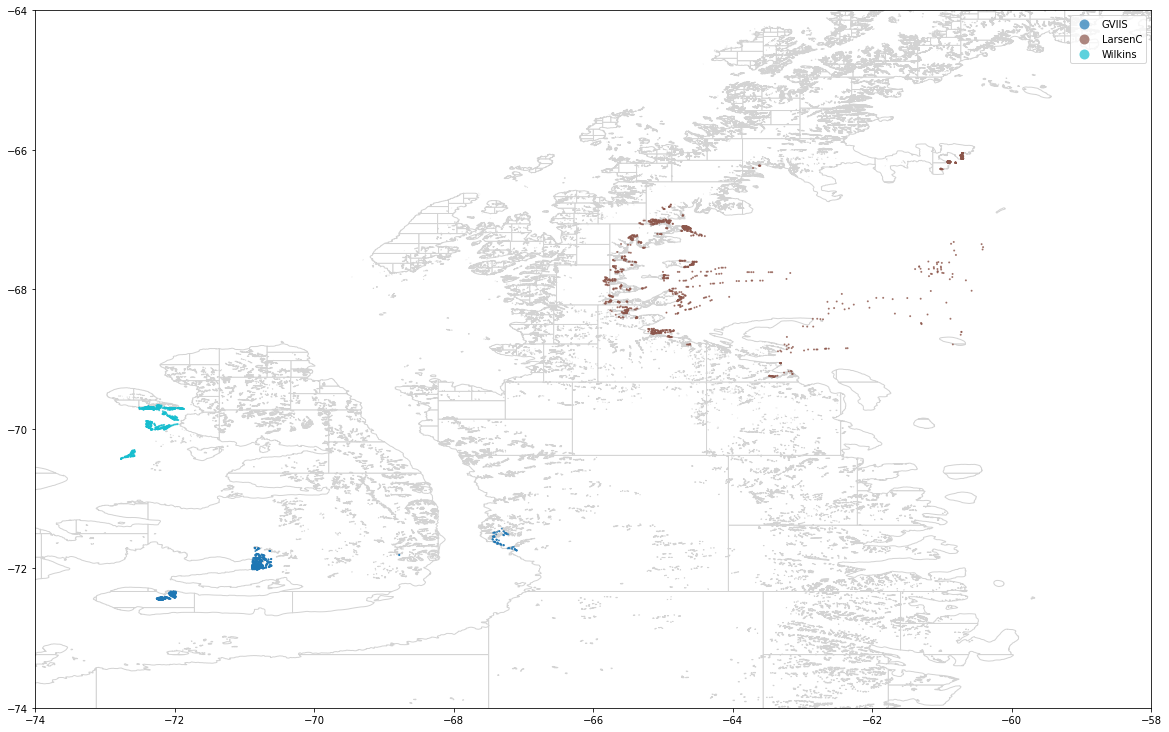

In [4]:
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
geoFracs.plot(ax=base,column="shelf",markersize=1,alpha=0.7,legend=True)
plt.show()

### Plot coloured by fracture/non-fracture

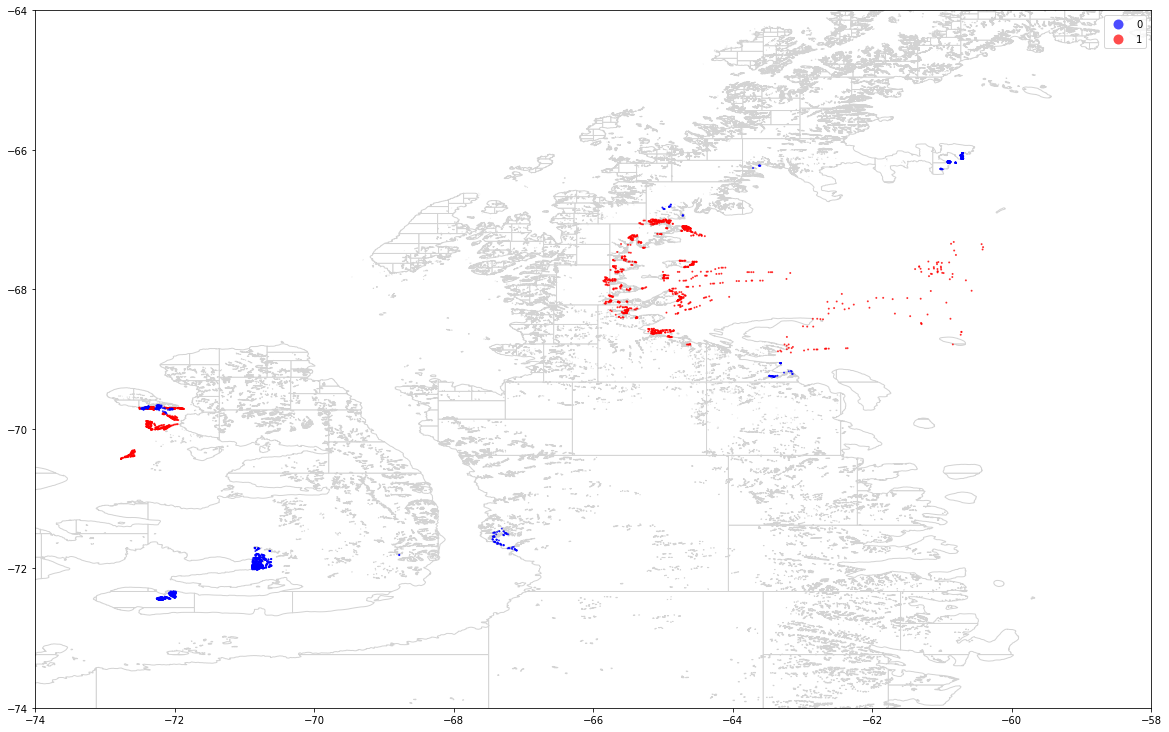

In [5]:
geoFracs.Fractured = geoFracs.Fractured.astype("object")
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
geoFracs.plot(ax=base,column="Fractured",markersize=1,alpha=0.7,legend=True,cmap="bwr")
plt.show()

## Define inducing points by k-means clustering

In [6]:
from scipy import cluster

In [7]:
k = 180  # Number of clusters
clust = cluster.vq.kmeans(fracs.loc[:,["Longitude","Latitude"]], k, iter=100, thresh=1e-05, check_finite=True)

In [8]:
clust[0].shape

(180, 2)

In [9]:
centroids = gpd.GeoDataFrame(geometry=gpd.points_from_xy(clust[0][:,0],clust[0][:,1]))
centroids.crs = "EPSG:4326"

### Plot with inducing points in yellow

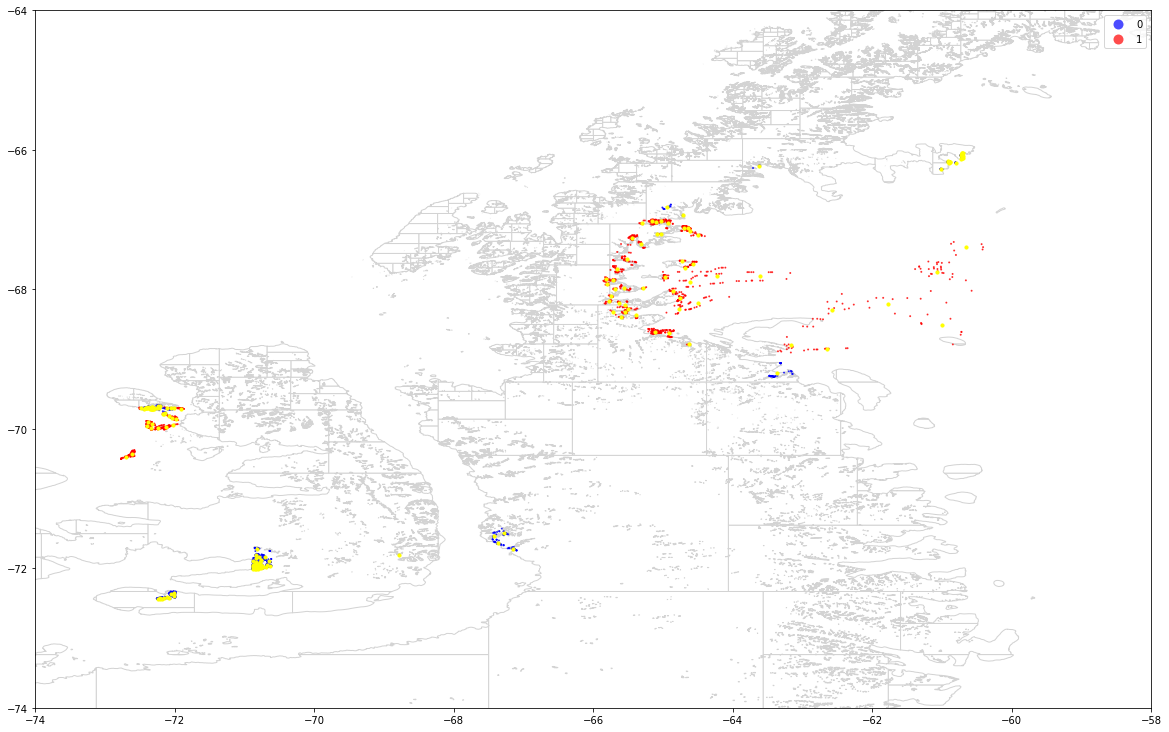

In [10]:
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
geoFracs.plot(ax=base,column="Fractured",markersize=1,alpha=0.7,legend=True,cmap="bwr")
centroids.plot(ax=base,markersize=10,color="yellow")
plt.show()

## Simple logistic regression model 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [12]:
predictors = ['Observed Velocity',
       'Modelled Velocity ', 'Damage', 'BackStress', 'Rheology', 'Pstress1',
       'Pstress2', 'EffStress', 'Pstrain1', 'Pstrain2', 'EffStrain',
       'Thickness']

In [13]:
Y = fracs.Fractured.to_numpy(dtype="float64")
X = fracs.loc[:,predictors]
X = ((X-X.mean(0))/X.std(0)).to_numpy() # Standardizing predictors

Below, I fit a logistic regression model with a penalty on the $\ell_2$ norm of the coefficients. This is equivalent to the *maximum a posteriori* (MAP) estimator in a Bayesian analysis with a normal prior on the coefficients. 

In [14]:
glm = LogisticRegression(penalty='l2')
parameters = {'C':[1, 2, 3, 4]}
clf = GridSearchCV(glm, parameters)
clf.fit(X,Y)

GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [1, 2, 3, 4]})

In [15]:
clf.cv_results_

{'mean_fit_time': array([0.02620158, 0.02680149, 0.02900176, 0.03200173]),
 'std_fit_time': array([0.00248199, 0.00402029, 0.00565708, 0.00379485]),
 'mean_score_time': array([0.00039997, 0.00019999, 0.00019999, 0.00020003]),
 'std_score_time': array([0.00048986, 0.00039997, 0.00039997, 0.00040007]),
 'param_C': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}, {'C': 2}, {'C': 3}, {'C': 4}],
 'split0_test_score': array([0.99120879, 0.99120879, 0.99120879, 0.99120879]),
 'split1_test_score': array([0.83846154, 0.83846154, 0.83846154, 0.83846154]),
 'split2_test_score': array([0.96593407, 0.96593407, 0.96593407, 0.96813187]),
 'split3_test_score': array([0.60879121, 0.60989011, 0.60879121, 0.60989011]),
 'split4_test_score': array([0.90659341, 0.90549451, 0.90549451, 0.90549451]),
 'mean_test_score': array([0.8621978 , 0.8621978 , 0.86197802, 0.86263736]),
 'std_test_score': array([0.

Fit the model with regularisation parameter $C=1$.

In [16]:
glm = LogisticRegression(penalty='l2',C=1)
res = glm.fit(X,Y)

Classification accuracy on the training set.

In [17]:
 res.score(X,Y)

0.9140659340659341

Coefficient estimates.

In [18]:
print("%20.20s: %.3f"%("Intercept",res.intercept_[0]))
for i in range(len(predictors)):
    print("%20.20s: %.3f"%(predictors[i],res.coef_[0,i]))

           Intercept: 0.719
   Observed Velocity: 1.377
  Modelled Velocity : 1.359
              Damage: 2.180
          BackStress: -1.236
            Rheology: 0.463
            Pstress1: -0.328
            Pstress2: 0.062
           EffStress: 2.128
            Pstrain1: -2.377
            Pstrain2: -0.124
           EffStrain: 1.353
           Thickness: -1.015


Based on model predictions, classify points as true positive, true negative, false positive, false negative.

In [19]:
geoFracs["Predicted"] = res.predict(X)
geoFracs["PredictionOutcome"] = "TP"
geoFracs.loc[(geoFracs.Fractured==0) & (geoFracs.Predicted==0),"PredictionOutcome"] = "TN"
geoFracs.loc[(geoFracs.Fractured==0) & (geoFracs.Predicted==1),"PredictionOutcome"] = "FP"
geoFracs.loc[(geoFracs.Fractured==1) & (geoFracs.Predicted==0),"PredictionOutcome"] = "FN"

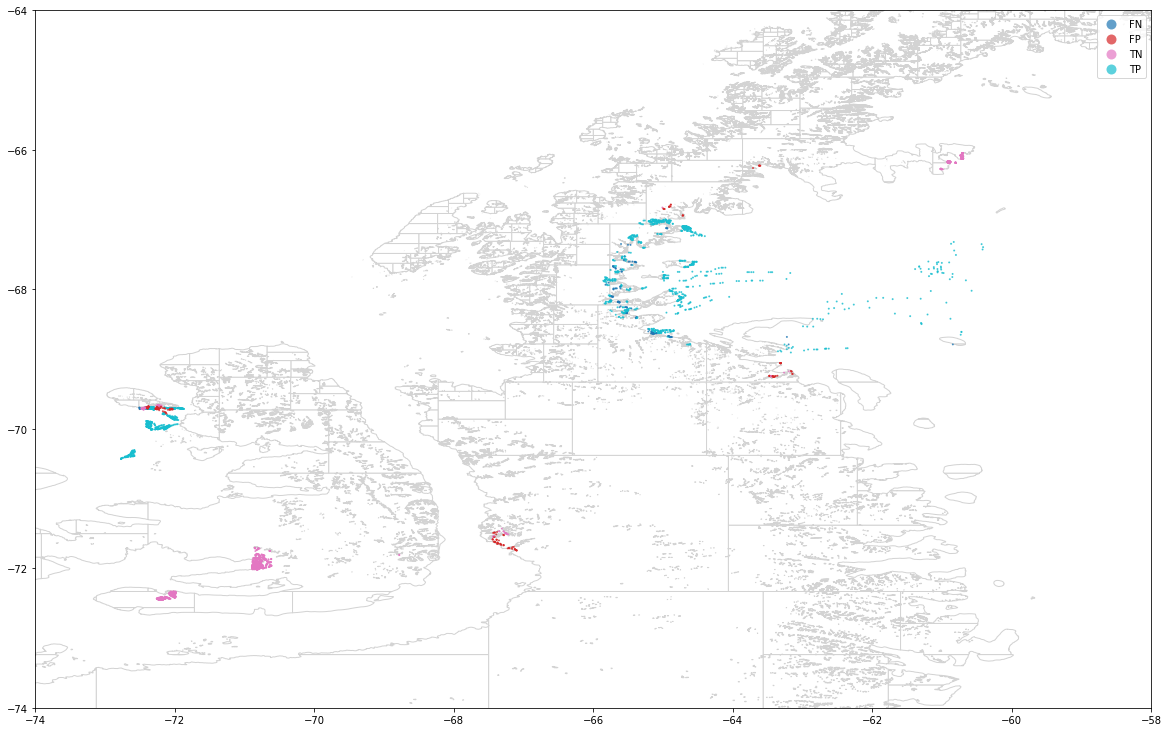

In [20]:
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
geoFracs.plot(ax=base,column="PredictionOutcome",markersize=1,alpha=0.7,legend=True)
plt.show()

### What is wrong with this model?

The story here seems quite simple. The largest cluster of non-fracture points is in George VII S, and the regressor is learning to distinguish these points from the fracture points, mainly in Larsen C and Wilkins, which are more disperse. This is why there are many false positives (non-fractures predicted as fractures) outside the big cluster in George VII S. 

Even though the accuracy of the logistic regression is high, it would be quite wrong to interpret the coefficients as indicating a causal relationship between ISSM predictors and fractures. More likely, there are other features which differ between iceshelves which could explain the propensity of a fracture, and it is also possible to distinguish the iceshelves using some combination of our 13 ISSM predictors. 

Emetc et al. deal with this issue by splitting the iceshelves into regions, fitting separate logistic regression models, and finding a consensus of the coefficients. This can lead to several problems:

1. Sensitivity to the definition of regions
2. Difficulty in interpreting credible intervals
3. Difficulty in interpreting variable selection

**Solution**: We will try to use an alternative method, which models all the data simultaneously. We will model latent features which could explain the difference between iceshelves (or within a large iceshelf such as Larsen) explicitly, through a function which is assumed to vary slowly in space. This will be done through a binomial regression with a spatial random effect, which is given a Gaussian process prior.

## Sparse GPs for probit regression with spatial random effects

Let $y_i$ be a binary response (fracture/non-fracture) for a point $i$. The design matrix $X$ has the following format. The first column indicates whether this is a sample point (1), or not (0). For a sample point, the second and third columns are longitude and latitude. The remaining $p$ columns correspond to the linear predictors.  

We will be using the following probit regression model for data $(y_i, x_i)_{i=1,\dots,n}$:

$ \Phi^{-1}(p(y_i=1\mid x_i)) = x_i[3:p+3]^T\beta + g(x_i[1,2])$

with a prior $\beta \sim N(0,\sigma^2_\text{fixed} I)$ on the fixed effects coefficients, and a Gaussian process prior $g\sim N(0,\sigma^2_\text{random}k_\lambda)$ on the random effects. We'll let $k_\lambda$ be a radial basis function kernel with bandwidth $\lambda$. If we define

$f(x) = 
\begin{cases}
x[3:]^T\beta +  g(x[1,2]) & \text{if } x[0]=1 \\
x[3:]^T\beta & \text{if } x[0]=0.
\end{cases}
$

then the function $f$ is itself a Gaussian process *a priori* with mean 0 and covariance function:

$k(x,x') = 
\begin{cases}
\sigma_\text{random}^2 k_\lambda(x[1,2],x'[1,2]) + \sigma_\text{fixed}^2 x[3:]^T x'[3:] & \text{if }x[0]=x'[0]=1 \\
\sigma_\text{fixed}^2 x[3:]^T x'[3:]  & \text{otherwise}
\end{cases}
$

### Inference

Approximate Bayesian inference will be done using the Sparse GP MCMC method introduced in the paper:

Hensman et al. *MCMC for Variatinoally Sparse Gaussian Processes*. NIPS, 2015.

We use the implementation in the package `GPFlow`.

The representation of the kernel is important because it allows us to represent a linear coefficient $\beta_i$ as an evaluation of $f$ at $(0,0,0,e_i)$ where $e_i$ is the $i$th Cartesian basis vector. This will let us use the coefficients as inducing points in the Sparse GP approximation.

### Prepare data and define kernel

In [21]:
import matplotlib
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable
from gpflow.utilities import print_summary, positive

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)

%matplotlib inline

Define a kernel for logistic regression with random effects, which will allow us to use the fixed coefficients as inducing points. 

In [22]:
class MixedModelKernel(gpflow.kernels.Kernel):
    """ For inputs of the type (i,z,x) where i is of length 1, z is of length 2, and x of length p, 
    this implements the kernel
    
    k((0,z,x),(0,z',x')) = x^T x' * sigmaBeta2
    k((0,z,x),(1,z',x')) = x^T x' * sigmaBeta2
    k((1,z,x),(1,z',x')) = x^T x' * sigmaBeta2 + RBF(z,z') * sigmaF2
    """
    def __init__(self,p):
        super().__init__(active_dims=np.arange(p+3))
        self.kernelRandom = gpflow.kernels.SquaredExponential(active_dims=[1,2])
        self.kernelFixed = gpflow.kernels.Linear(active_dims=range(3,p+3))
        
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.kernelFixed(X,X2) + \
               tf.tensordot(tf.cast(X[:,0]==1,dtype=tf.float64),
                            tf.cast(X2[:,0]==1,dtype=tf.float64),axes=0) * self.kernelRandom(X,X2)
            
    def K_diag(self, X):
        return self.kernelFixed(X,X2=None,full_cov=False) + \
               tf.where(X[:,0]==1,self.kernelRandom(X,X2=None,full_cov=False),0)

In [23]:
## Test kernel
#p=3
#X = np.ones([4,p+3])
#X[:,0] = [0,0,1,1]
#X = tf.convert_to_tensor(X,dtype=tf.float64)

#k = MixedModelKernel(p)
#print(k(X,X))
#print(k(X,X2=None,full_cov=False))

# Create some dummy data
#p = 15
#n = 5000
#X = np.random.rand(n,p+3)
#X[:,0] = 1
#Y = np.random.randint(2, size=n).reshape(n,1)
#data = (X,Y)

Prepare the data for SGPMC model

In [24]:
p = len(predictors)+1   # Number of predictors including intercept
n = fracs.shape[0]      # Number of samples
Y = fracs.Fractured.to_numpy(dtype="float64").reshape(n,1)
X = fracs.loc[:,predictors]
X = ((X-X.mean(0))/X.std(0)).to_numpy()     # Standardize predictors
coords = fracs.loc[:,["Longitude","Latitude"]].to_numpy()
X = np.concatenate([np.ones([X.shape[0],1]),coords,np.ones([X.shape[0],1]),X],axis=1)
data = (X,Y)

The inducing variables include the linear coefficients $\beta$, as well as the random effects function $g$ evaluated at 150 locations obtained above through a k-means clustering of the samples. 

In [25]:
# Inducing variables for coefficients beta
inducing = []
for i in range(p):
    inducing.append([0]*(3+i)+[1]+[0]*(p-i-1)) 
# Inducing variables for random effects at k-means clustering locations
for i,j in clust[0]:
    inducing.append([1,i,j]+[0]*p)
inducing = np.array(inducing,dtype="float64")

### Building the model and computing the maximum a posteriori (MAP) estimator

In [26]:
kernel = MixedModelKernel(p)

model = gpflow.models.SGPMC(
    data,
    kernel=kernel,
    likelihood=gpflow.likelihoods.Bernoulli(),
    inducing_variable=inducing,
    num_latent_gps=1,
)

## These settings reproduce something quite similar to the model without random effects,
## i.e. sigma^2_random ~ 0 
#set_trainable(model.kernel.kernelRandom.variance,False)
#model.kernel.kernelRandom.variance.assign(0.0001)
#model.kernel.kernelFixed.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

# Put exponential priors on the variance of fixed and random effects
model.kernel.kernelRandom.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernelFixed.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

#ADD PRIOR TO LENGTHSCALE
model.kernel.kernelRandom.lengthscales.prior = tfd.Normal(f64(1.0), f64(1.0))

# Fix the lengthscale of the random effects RBF kernel, and fix the inducing points
#set_trainable(model.kernel.kernelRandom.lengthscales, False)
#model.kernel.kernelRandom.lengthscales.assign(1.0)
set_trainable(model.inducing_variable,False)

gpflow.utilities.print_summary(model)

In [27]:
model.kernel.kernelRandom.lengthscales.prior

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float64>

Using the notation of Hensman et al., the chain of samples for $\mathbf{u}_c, \theta$ is initialized at the value maximizing  $p(Y|\mathbf{u}_c, \theta)$.

In [28]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables, options={"maxiter": 1000})
print(f"log posterior density at optimum: {model.log_posterior_density()}")

log posterior density at optimum: -447.60148349515106


In [29]:
gpflow.utilities.print_summary(model)

Make predictions with the model and evaluate the number of correct classifications on the training set.

In [30]:
preds = (model.predict_f(X)[0].numpy().flatten()>0.5)

In [31]:
(fracs.Fractured==preds).sum()/len(preds)

0.9905494505494505

This shows the MAP model has a very high accuracy on the training set.

Show the value of the coefficients at the MAP estimator.

In [32]:
coefs = model.predict_f(inducing)[0].numpy()
print("%20.20s: %.3f"%("Intercept",coefs[0]))
for i in range(len(predictors)):
    print("%20.20s: %.3f"%(predictors[i],coefs[i+1]))

           Intercept: 5.544
   Observed Velocity: 2.281
  Modelled Velocity : -0.416
              Damage: 9.800
          BackStress: -2.830
            Rheology: 0.891
            Pstress1: -0.381
            Pstress2: -1.008
           EffStress: -2.721
            Pstrain1: -0.665
            Pstrain2: -1.691
           EffStrain: 1.822
           Thickness: 0.936


### Running Hamiltonian Monte Carlo sampling of the variational posterior

Sampling starts with a 'burn in' period.

In [33]:
num_burnin_steps = ci_niter(2500)
num_samples = ci_niter(10000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


In [34]:
from time import time
s1=time()

samples1, _ = run_chain_fn()
#samples2, _ = run_chain_fn()
#samples3, _ = run_chain_fn()
constrained_samples1 = hmc_helper.convert_to_constrained_values(samples1)
#constrained_samples2 = hmc_helper.convert_to_constrained_values(samples2)
#constrained_samples3 = hmc_helper.convert_to_constrained_values(samples3)

e1 = time()
print((e1-s1)/3600)

3.1143834102816053


### Convergence diagnostics

In [35]:
#cstensor1 = tf.convert_to_tensor(constrained_samples1[0])
#cstensor1 = tf.reshape(cstensor1,[10000,1,161])
#cstensor2 = tf.convert_to_tensor(constrained_samples2[0])
#cstensor2 = tf.reshape(cstensor2,[10000,1,161])
#cstensor3 = tf.convert_to_tensor(constrained_samples3[0])
#cstensor3 = tf.reshape(cstensor3,[10000,1,161])

#three_chains = tf.concat([cstensor1,cstensor2,cstensor3],1)
#three_chains

In [36]:
#CT = tfp.mcmc.potential_scale_reduction(three_chains)

In [37]:
#CT.numpy()

MCMC trace of hyperparameters $\sigma_\text{fixed}^2$ and $\sigma_\text{random}^2$.

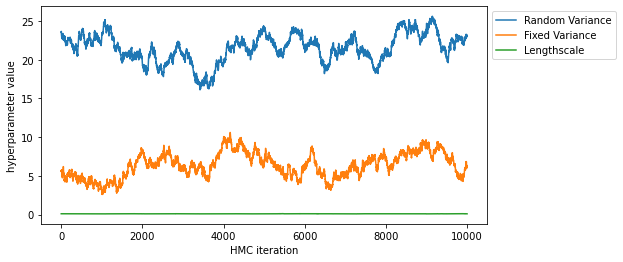

In [38]:
param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in enumerate(model.trainable_parameters)}
hyperparameters = [".kernel.kernelRandom.variance", ".kernel.kernelFixed.variance",".kernel.kernelRandom.lengthscales"]

plt.figure(figsize=(8, 4))
for param_name in hyperparameters:
    plt.plot(constrained_samples1[name_to_index[param_name]], label=param_name)
plt.legend(('Random Variance', 'Fixed Variance', 'Lengthscale'),bbox_to_anchor=(1.0, 1.0))
plt.xlabel("HMC iteration")
_ = plt.ylabel("hyperparameter value")
plt.savefig('Inducing_points/HS_priorNormal_HyperValues_IP180.png',dpi=400)

In [39]:
model

name                                    class      transform    prior    trainable    shape      dtype    value
--------------------------------------  ---------  -----------  -------  -----------  ---------  -------  -------------------
SGPMC.kernel.kernelRandom.variance      Parameter  Softplus     Gamma    True         ()         float64  22.979474154842478
SGPMC.kernel.kernelRandom.lengthscales  Parameter  Softplus     Normal   True         ()         float64  0.10059492962745273
SGPMC.kernel.kernelFixed.variance       Parameter  Softplus     Gamma    True         ()         float64  6.292928031661853
SGPMC.inducing_variable.Z               Parameter                        False        (193, 16)  float64  [[0., 0., 0....
SGPMC.V                                 Parameter               Normal   True         (193, 1)   float64  [[1.67549657e+00...

### Visualising the posterior distribution of the linear coefficients

In [40]:
coef_samples = model.predict_f_samples(inducing[0:p,:],1000).numpy()

In [41]:
model.predict_f_samples

<bound method GPModel.predict_f_samples of <gpflow.models.sgpmc.SGPMC object at 0x0000000013B3A608>>

In [42]:
coef_samples = pd.DataFrame(coef_samples[:,:,0])

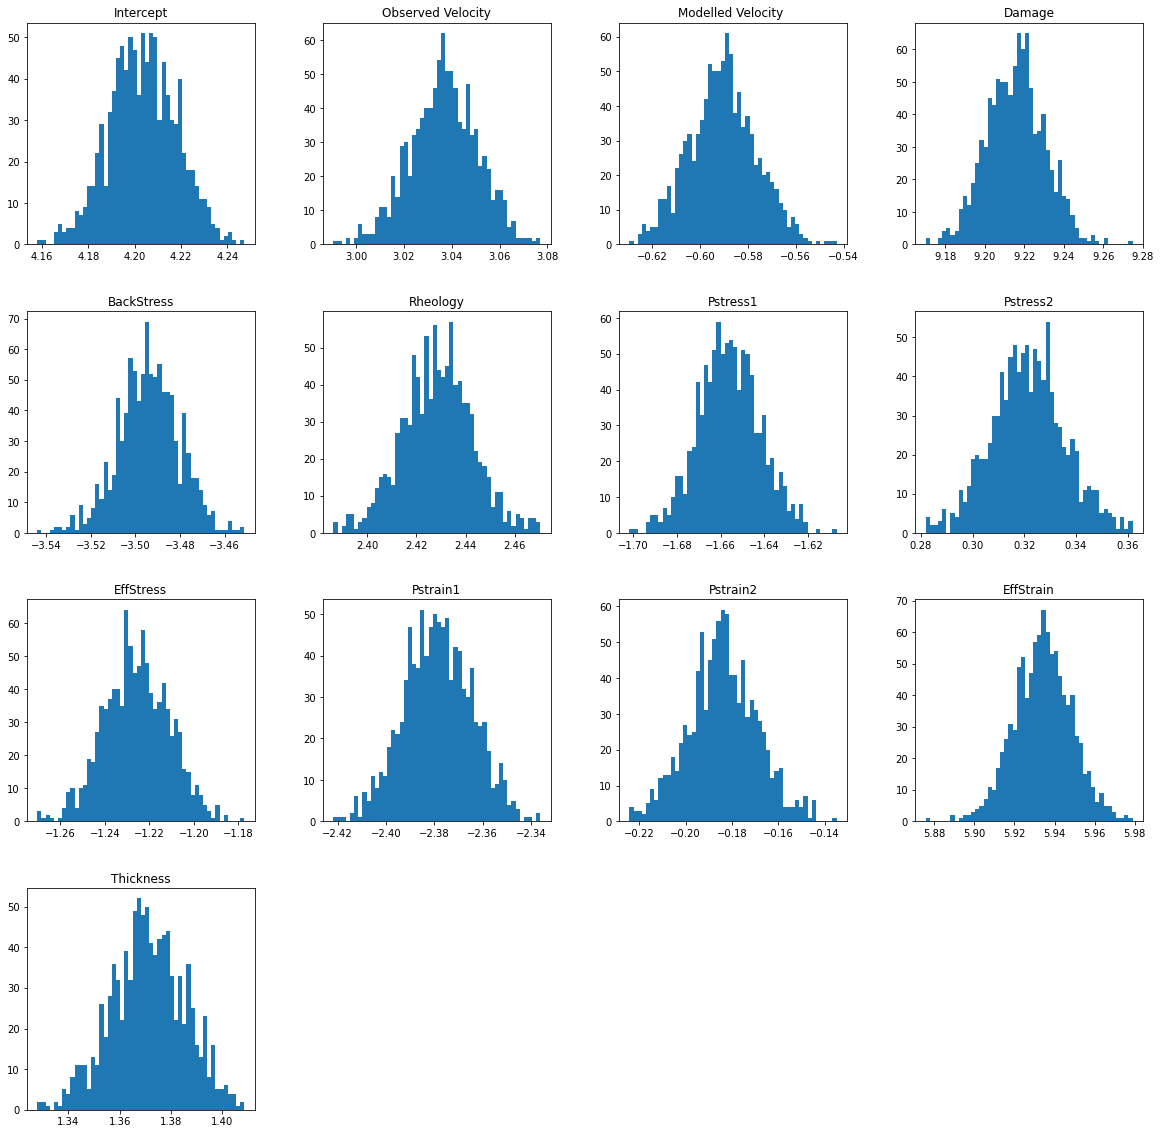

In [43]:
coef_samples.columns = ["Intercept"]+predictors
coef_samples.hist(figsize=[20,20],bins=50,grid=False)
plt.savefig('Inducing_points/HS_priorNormal_Distributions_IP180.png',dpi=400)
plt.show()

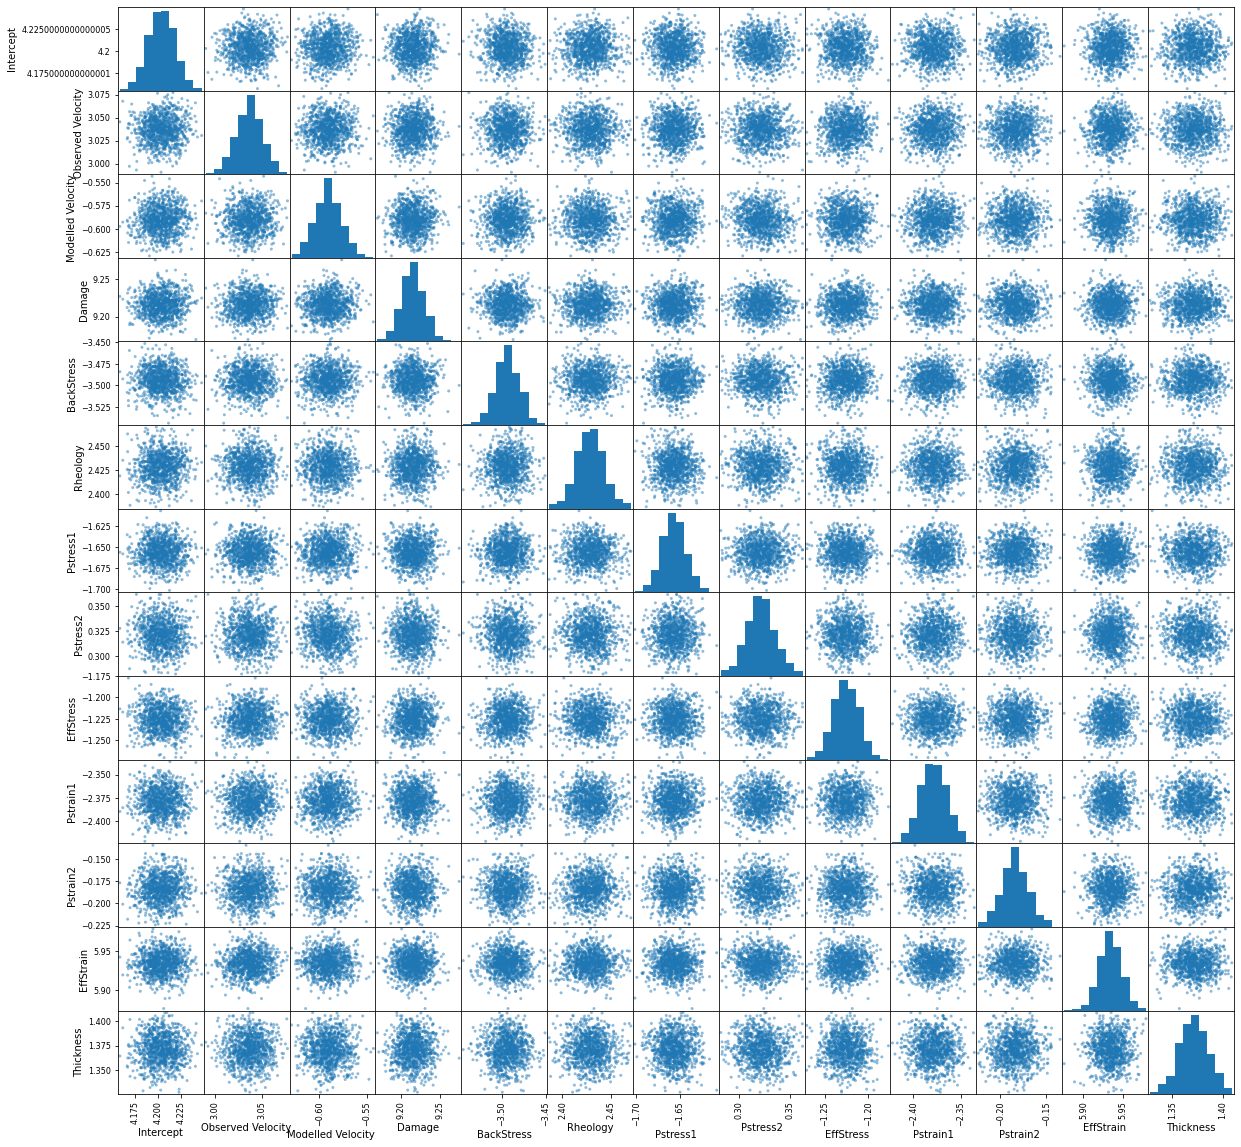

In [44]:
pd.plotting.scatter_matrix(coef_samples,figsize=(20,20))
plt.savefig('Inducing_points/HS_priorNormal_scatter_IP120.png',dpi=400)
plt.show()

**Interpretation**

Remarkably, the posterior of all coefficients is supported on a set away from 0, which suggests the correlations with fractures are "statistically significant" even after including a smoothly varying random effect. The most important variables seem to be Damage, Modelled and Observed Velocity, and EffStrain. 

Note that some of the predictors are highly correlated (eg. modelled and observed velocity). In a standard, non-penalised logistic regression, we would expect a negative correlation in the coefficients. However, the prior regularises the coefficients, which explains the lack of a strong correlation in the posterior. 

### Visualising the predictions of the model spatially

We begin by plotting the prediction of the model $p(y=1 \mid x)$ as a function of the predictors $x$ for the grid locations in the ISSM datasets. We show the posterior mean and variance of the function $p(y=1 \mid x)$.

In [45]:
# Load ISSM data on grid
ISSM_DFs = []
shelves = ["GVIIS", "Wilkins", "LarsenC"]
for shelf in shelves:
    ISSM_predictors = pd.read_csv("data/NEW_SETUP_"+shelf+"_ISSMoutputs_200x200.csv")
    ISSM_predictors.dropna(inplace=True)   # Drop all grid points with NA values
    ISSM_DFs.append(ISSM_predictors)
ISSM_predictors = pd.concat(ISSM_DFs)

In [46]:
Xnew = ISSM_predictors.loc[:,predictors]
Xnew = ((Xnew-Xnew.mean(0))/Xnew.std(0)).to_numpy()     # Standardize predictors
coords = ISSM_predictors.loc[:,["Lon","Lat"]].to_numpy()
Xnew = np.concatenate([np.ones([Xnew.shape[0],1]),coords,np.ones([Xnew.shape[0],1]),Xnew],axis=1)

In [47]:
preds = model.predict_y(Xnew)
ISSM_predictors["Predicted_y"] = preds[0].numpy()
ISSM_predictors["Predicted_y_var"] = preds[1].numpy()

In [48]:
ISSM_predictors = gpd.GeoDataFrame(ISSM_predictors,
                                   geometry=gpd.points_from_xy(ISSM_predictors.Lon,ISSM_predictors.Lat))
ISSM_predictors.crs = "EPSG:4326"

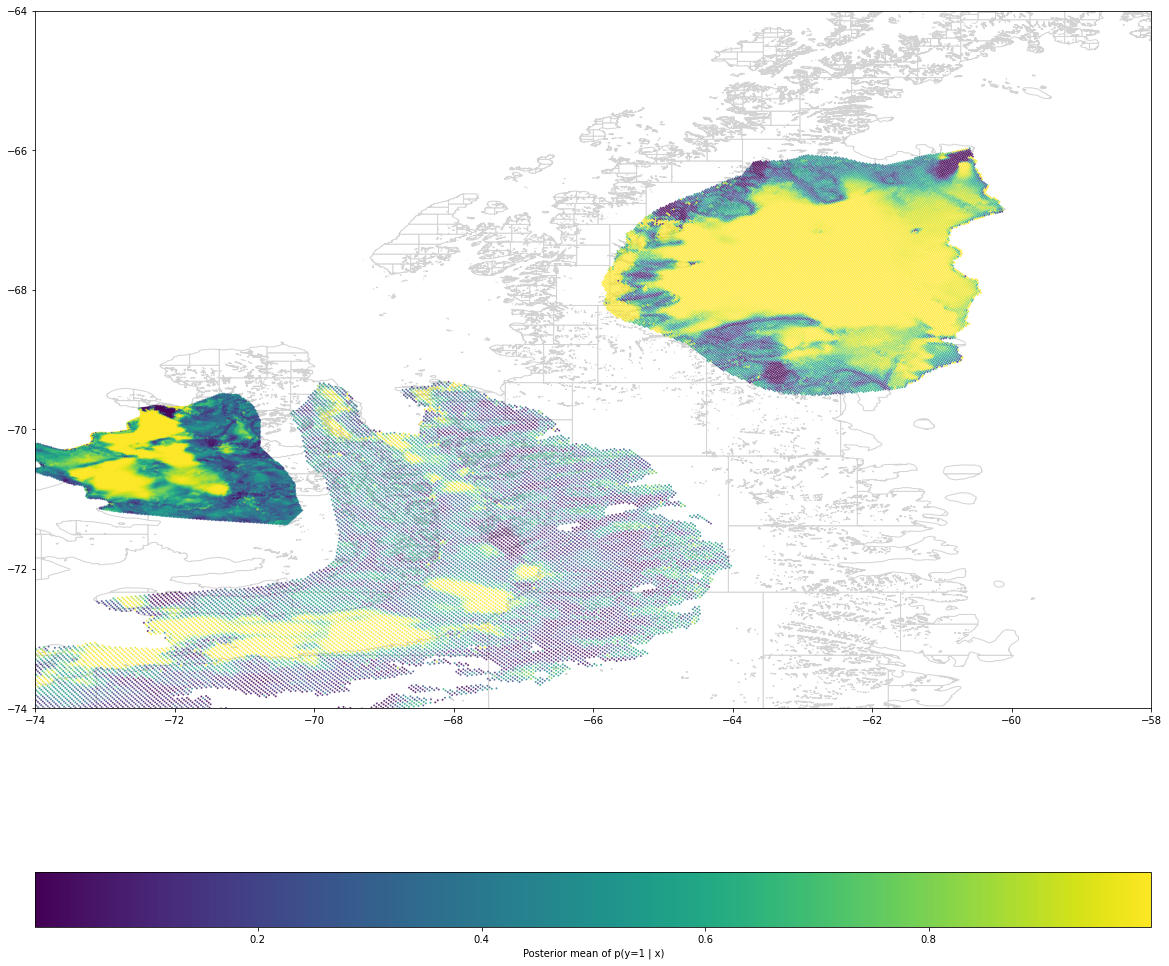

In [49]:
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
ISSM_predictors.plot(ax=base,column="Predicted_y",markersize=1,alpha=0.7,
                     legend=True, 
                     legend_kwds={'label': "Posterior mean of p(y=1 | x)",'orientation': "horizontal"})
plt.savefig('Inducing_points/HS_priorNormal_FixedMean_IP180.png',dpi=400)
plt.show()

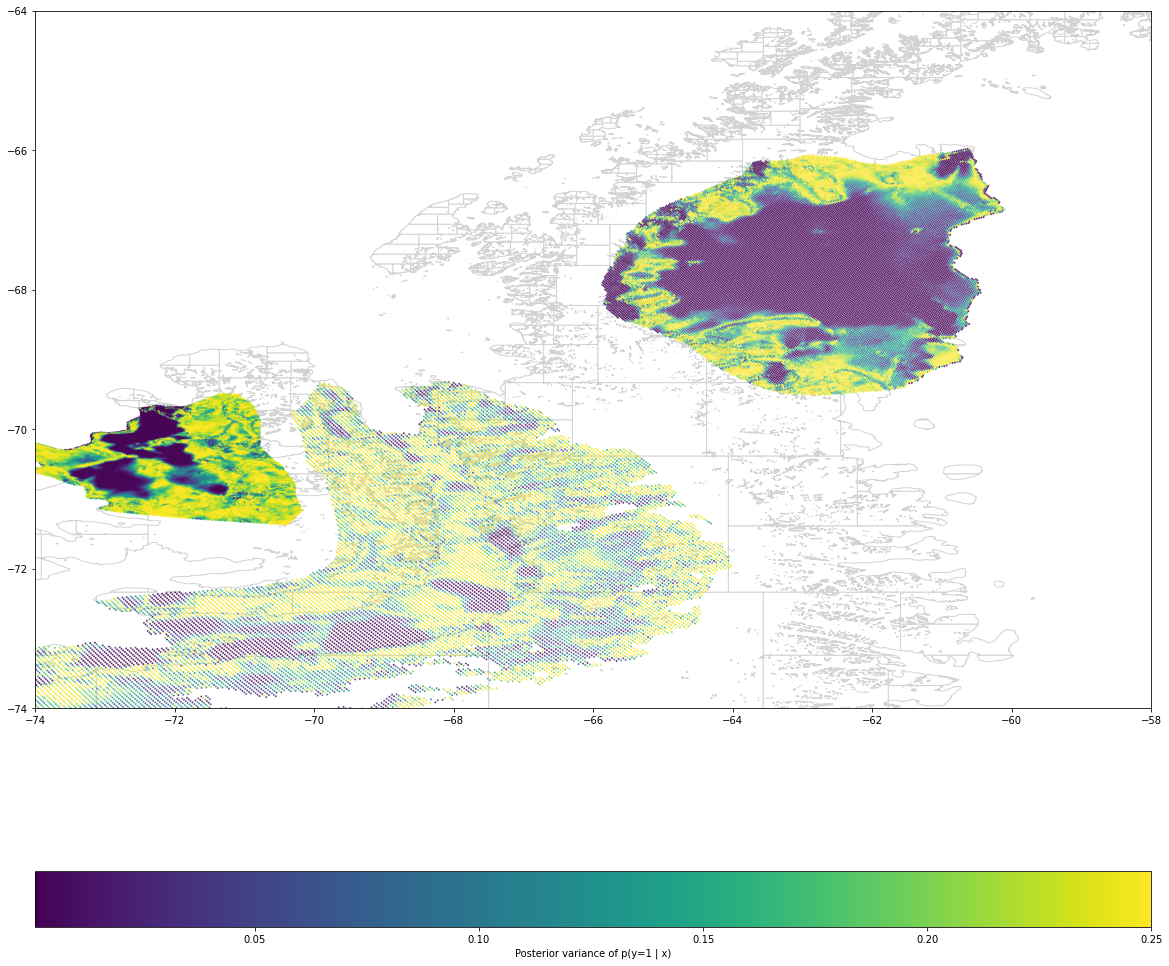

In [50]:
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
ISSM_predictors.plot(ax=base,column="Predicted_y_var",markersize=1,alpha=0.7,
                     legend=True, 
                     legend_kwds={'label': "Posterior variance of p(y=1 | x)",'orientation': "horizontal"})
plt.savefig('Inducing_points/HS_priorNormal_FixedVar_IP180.png',dpi=400)
plt.show()

Naturally, there's higher variance (more uncertainty) in the boundaries between the fracture and non-fracture zones.

Below we show plots of the posterior mean and variance of the random effects function $g$. 

In [51]:
coords = ISSM_predictors.loc[:,["Lon","Lat"]].to_numpy()
Xnew = np.concatenate([np.ones([coords.shape[0],1]),coords,np.zeros((coords.shape[0],p+3))],axis=1)

In [52]:
preds = model.predict_f(Xnew)
ISSM_predictors["Predicted_g"] = preds[0].numpy()
ISSM_predictors["Predicted_g_var"] = preds[1].numpy()

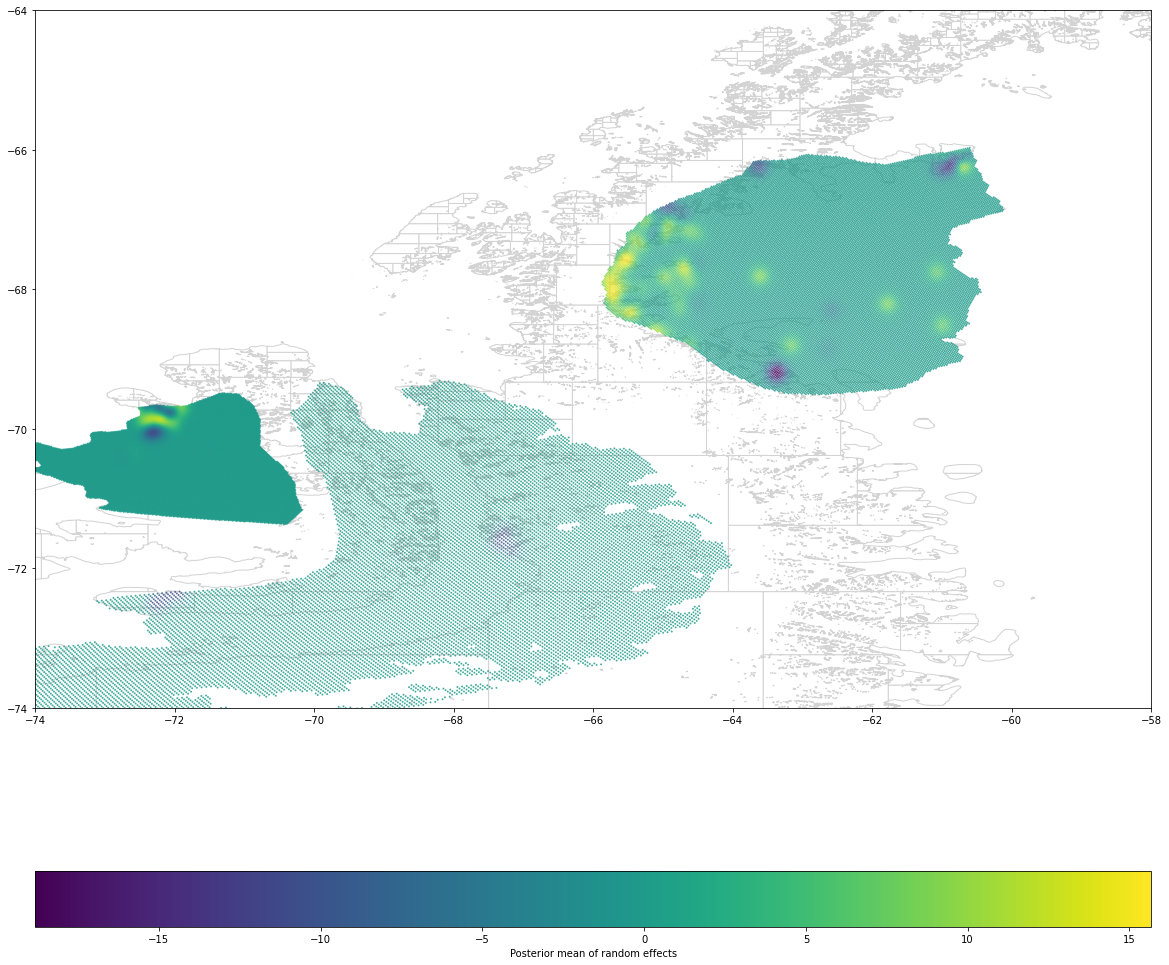

In [53]:
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
ISSM_predictors.plot(ax=base,column="Predicted_g",markersize=1,alpha=0.7,
                     legend=True, 
                     legend_kwds={'label': "Posterior mean of random effects",'orientation': "horizontal"})
plt.savefig('Inducing_points/HS_priorNormal_RandMean_IP180.png',dpi=400)
plt.show()

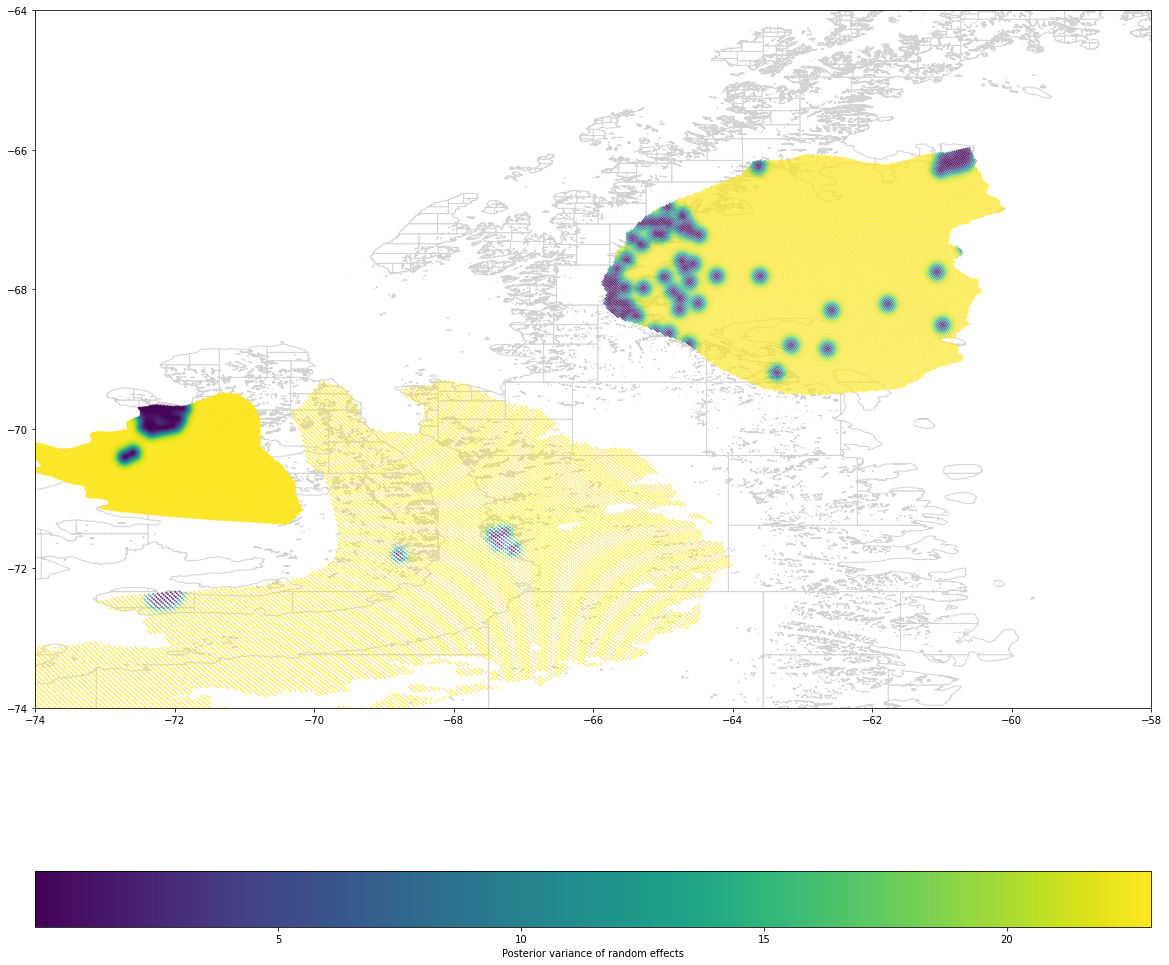

In [54]:
base = iceshelves.plot(color="white",edgecolor="lightgrey",figsize=(20,20))
plt.xlim([-74,-58]) 
plt.ylim([-74,-64])
ISSM_predictors.plot(ax=base,column="Predicted_g_var",markersize=1,alpha=0.7,
                     legend=True, 
                     legend_kwds={'label': "Posterior variance of random effects",'orientation': "horizontal"})
plt.savefig('Inducing_points/HS_priorNormal_RandVar_IP180.png',dpi=400)
plt.show()

### Session information

In [ ]:
from sinfo import sinfo
sinfo()